In [1]:
import sys
sys.path.append('/home/lev/object-centric/edge-generation/models/')
import torch_geometric
import torch
from omegaconf import OmegaConf
from dataloader import PL_DataModule
from models.model import Network
import matplotlib.pyplot as plt
import hydra
import matplotlib.pyplot as plt

from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import confusion_matrix
import numpy as np
# own modules
from dataloader import PL_DataModule
from method import LitModel

initialize(config_path='outputs/2022-02-11/10-36-18/.hydra/', job_name="test_app")


hydra.initialize()

In [2]:
def get_dataloader(cfg):
    return PL_DataModule(cfg.dataloader)
    
def get_model_loaders(weights_path):
    cfg = compose(config_name="config")
    print(cfg)
    # Setup dataloader and model
    datamodule = get_dataloader(cfg)

    # Obtain feature sizes and number of labels
    batch = next(iter(datamodule.train_dataloader()))
    cfg.model.opt.loader_batches = len(datamodule.train_dataloader())
    cfg.model.insize ,cfg.model.outsize = batch.x.shape[1], torch.unique(batch.y).shape[0]
    model = LitModel(cfg=cfg)
    # upload weights
    state_dict = torch.load(weights_path)['state_dict']
    model.load_state_dict(state_dict)
    return model, datamodule


In [3]:
weights_path = '/home/lev/object-centric/edge-generation/outputs/2022-02-11/10-36-18/checkpoints/epoch=24-step=24.ckpt'

model, datamodule = get_model_loaders(weights_path)

batch = next(iter(datamodule.train_dataloader()))
model.model.loss_function(batch)

{'trainer': {'cuda_number': '2', 'gpus': 1, 'is_logger_enabled': False, 'num_sanity_val_steps': 5, 'check_val_every_n_epoch': 25, 'log_every_n_steps': 25}, 'wadb': {'logger_project_name': 'edge_generation_baselines', 'logger_name': 'None', 'entity': 'edge_generation'}, 'seed_everything': 1, 'dataloader': {'dataset_type': 'CustomDataset', 'dataset_name': 'molec-biol-splice', 'val_size': 0.3, 'data_seed': 223, 'graph_size': 'None', 'n_batches': 1, 'train_batch_size': 1, 'val_batch_size': 1, 'num_workers': 4, 'precompute_graph': 'None', 'precompute_graph_k': 3, 'graph_seed': 0, 'inter_class_k': 0, 'f1_svm': 0.0, 'acc_svm': 0.0}, 'model': {'type': 'EdgeNet', 'edge_generation_type': 'DynamicEdgeConv_DGM', 'in_channels': [60], 'out_channels': [60], 'insize': 'None', 'outsize': 'None', 'k': [3, 5], 'prob_reg': 0.0001, 'opt': {'lr': 0.004, 'warmup_steps_pct': 0.02, 'decay_steps_pct': 0.9, 'weight_decay': 0.0, 'max_epochs': 1000, 'scheduler_gamma': 0.5, 'loader_batches': 'None'}}, 'stat': {'ima

Global seed set to 1
/opt/anaconda3/envs/lev_eg/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/opt/anaconda3/envs/lev_eg/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


{'loss': tensor(1.4401, dtype=torch.float64, grad_fn=<AddBackward0>),
 'cross_entrop': tensor(0.9059, grad_fn=<NllLossBackward0>),
 'accuracy': tensor(0.6691),
 'f1': tensor([0.6670]),
 'avr_precision': tensor(0.7262),
 'aucroc': tensor(0.8342),
 'f1_svm': tensor(0.),
 'acc_svm': tensor(0.),
 'temperatue_0': tensor(0.0369),
 'temperatue_1': tensor(0.0335),
 'loss_prob': tensor(0.5341, dtype=torch.float64, grad_fn=<MulBackward0>)}

In [10]:
import os
import glob
import torch
import matplotlib.pyplot as plt
from PIL import Image
import sys
from PIL import Image
sys.path.append('/home/lev/')

class analize_dgm():
    def __init__(self):
        self.image_folder = '/home/lev/object-centric/edge-generation/images'
        self.workimage = WorkWithImage(image_folder = self.image_folder)
    
    def process(self, model, **args):
        self.model, self.d = model.model.model.model, {}

        clean_folder(folder=self.image_folder)
        self.temperature_stat()
        self.save_adj(args['batch'])
        self.save_edgeconv_probs()
        self.concat_img()
        

    def temperature_stat(self):
        self.d = {}
        for idx in range(len(self.model)):
            self.d[f"temperatue_{idx}"] =  self.model[idx].edge_conv.temperature.clone().detach()[0]

    def save_adj(self, batch):
        self.idxs = torch.argsort(batch.y)

        # Adj matrix
        probs = (batch.y.unsqueeze(0) == batch.y.unsqueeze(1)) * 1
        probs = permute_matrix(probs, self.idxs)
        self.workimage.save_heatmap(probs, name='adj.png', title=f'Adjacency')

    def save_edgeconv_probs(self):
        for idx in range(len(self.model)):
            probs = self.model[idx].edge_conv.probs.clone().detach().cpu()
            probs = permute_matrix(probs, self.idxs)
            self.workimage.save_heatmap(probs, name=f'prob_L{idx}.png', title=f'prob_L{idx}')

            mask = self.model[idx].edge_conv.mask.clone().detach().cpu()
            mask = permute_matrix(mask, self.idxs)
            self.workimage.save_heatmap(mask, name=f'mask_L{idx}.png', title=f'mask_L{idx}')



    
    def concat_img(self):
        paths = sorted(glob.glob( os.path.join(self.image_folder,'*.png')))
        adj = self.workimage.load(paths[0])

        for path in paths[1:]:
            adj = self.workimage.get_concat_h(adj, self.workimage.load(path))
        
        self.workimage.pil_save(im=adj, name='final.png')
        return adj

class WorkWithImage():
    def __init__(self, image_folder):
        self.image_folder = image_folder
        pass
    
    def load(self, path):
        return Image.open(path)

    def save_heatmap(self, data, name, title):
        self.heatmap(data,
                     image_folder=self.image_folder,
                     im_name=name, title=title,
                     cmap='hot', interpolation='nearest')
    
    def pil_save(self, im, name):
        self.pil_save_(im,
                       image_folder=self.image_folder,
                       name=name)


    @staticmethod
    def get_concat_h(im1, im2):
        dst = Image.new('RGB', (im1.width + im2.width, im1.height))
        dst.paste(im1, (0, 0))
        dst.paste(im2, (im1.width, 0))
        return dst

    @staticmethod
    def heatmap(data, image_folder, im_name, title='', **kwargs):
        """
        Create a heatmap from a numpy array and two lists of labels.

        Parameters
        ----------
        data
            A 2D numpy array of shape (M, N).
        cbar_kw
            A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
        **kwargs
            All other arguments are forwarded to `imshow`.
        """
        fig, ax = plt.subplots( nrows=1, ncols=1, dpi=100)
        
        # Plot the heatmap
        im = ax.imshow(data, **kwargs)
        # Create colorbar
        cbar = ax.figure.colorbar(im, ax=ax)

        path = os.path.join(image_folder, im_name)
        ax.set_title(title)
        #fig.savefig(path)

        #plt.close(fig) 
        return fig

    @staticmethod
    def pil_save_(im, image_folder, name):
        path = os.path.join(image_folder, name)
        im.save(path)

def clean_folder(folder):
    files = glob.glob(os.path.join(folder, '*'))
    for f in files:
        os.remove(f)



def check_if_file_exist(path): 
    return os.path.isfile(path) 

def permute_matrix(M, idx):
    M = M[idx, :]
    M = M[:, idx]
    return M

def cat_dicts(a, b):
    return dict(list(a.items()) + list(b.items()))

In [11]:
analize = analize_dgm()

In [9]:
analize.process(model=model, batch=batch)

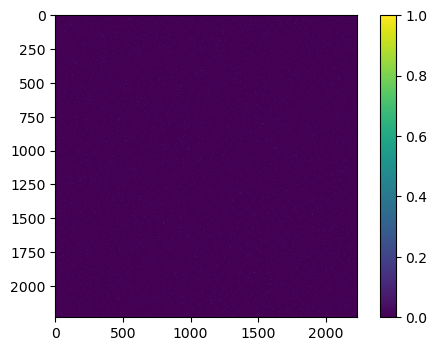

In [14]:
image_folder = '/home/lev/object-centric/edge-generation/images'
ww = WorkWithImage('/home/lev/object-centric/edge-generation/images')
f =  ww.heatmap(data = model.model.model.model[0].edge_conv.mask, image_folder=image_folder, im_name='a')

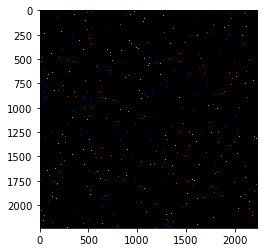

In [36]:
plt.imshow(image.reshape(2233,2233,-1), cmap='hot', interpolation='nearest')


In [153]:
probs = torch.nn.functional.pad(probs, (5,5), mode='constant', value=0.7)

In [154]:
probs.shape

torch.Size([1, 2233, 2255])

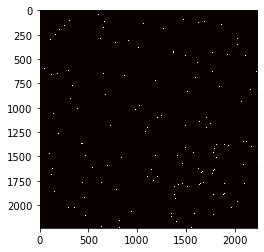

In [37]:

plt.imshow(model.model.model.model[0].edge_conv.mask, cmap='hot', interpolation='nearest')

In [38]:
mask = model.model.model.model[0].edge_conv.mask

### LOG as slot-attention

In [87]:
# C, H, W
mask = model.model.model.model[0].edge_conv.mask.unsqueeze(0)

# C, H, W
adj = ((batch.y == batch.y.unsqueeze(1))*1).unsqueeze(0)

idx = torch.argsort(batch.y)
mask = mask[:, idx, :]
mask = mask[:, :, idx]

adj = adj[:, idx, :]
adj = adj[:, :, idx]

out = torch.cat([mask.unsqueeze(0), adj.unsqueeze(0)], dim=0)

images = vutils.make_grid(out.cpu(), normalize=False, nrow=2)

In [134]:
idx = torch.argsort(batch.y)




In [137]:

def permute_CHW(M, idx):
    M = M[:, idx, :]
    M = M[:, :, idx]
    return M

m = model.model.model.model
adj = permute_CHW(((batch.y == batch.y.unsqueeze(1)) * 1).unsqueeze(0), idx)

out = [adj*0.5]
for i in range(len(m)):
    probs = permute_CHW(m[i].edge_conv.probs.unsqueeze(0), idx=idx)
    masks = permute_CHW(m[i].edge_conv.mask.unsqueeze(0), idx=idx)

    out.extend([probs,
                masks])

out = torch.cat(out, dim=0).unsqueeze(1)
images = vutils.make_grid(out.cpu(), normalize=False, nrow=1)
images = torch.swapaxes(images,2,1)

In [141]:
from pytorch_lightning import Callback

In [144]:
model

LitModel(
  (model): Network(
    (model): EdgeNet(
      (model): Sequential(
        (0): Sequential(
          (edge_conv): DynamicEdgeConv_DGM()
          (act): ReLU()
        )
        (1): Sequential(
          (edge_conv): DynamicEdgeConv_DGM()
        )
      )
    )
    (crossentropy): CrossEntropyLoss()
    (acc): Accuracy()
    (avr_precision): AveragePrecision()
    (aucroc): AUROC()
  )
)

import wandb
import random


from torchvision import utils as vutils


random.seed(1)
wandb.init()
# define a metric we are interested in the minimum of
wandb.define_metric("loss", summary="min")
# define a metric we are interested in the maximum of
wandb.define_metric("acc", summary="max")
for i in range(1):
  log_dict = {
      "loss": random.uniform(0,1/(i+1)),
      "acc": random.uniform(1/(i+1),1),
      "im": wandb.Image(images)
  }
  wandb.log(log_dict)

[Sequential(
   (edge_conv): DynamicEdgeConv_DGM()
 ),
 DynamicEdgeConv_DGM(),
 Sequential(
   (0): Linear(in_features=120, out_features=3, bias=True)
   (1): ReLU()
   (2): Linear(in_features=3, out_features=3, bias=True)
 ),
 Linear(in_features=120, out_features=3, bias=True),
 ReLU(),
 Linear(in_features=3, out_features=3, bias=True),
 Sequential(
   (0): Linear(in_features=60, out_features=60, bias=True)
   (1): ReLU()
   (2): Linear(in_features=60, out_features=60, bias=True)
 ),
 Linear(in_features=60, out_features=60, bias=True),
 ReLU(),
 Linear(in_features=60, out_features=60, bias=True)]

In [78]:
import wandb
import random


from torchvision import utils as vutils
#image = vutils.make_grid(model.model.model.model[0].edge_conv.mask)

random.seed(1)
wandb.init()
# define a metric we are interested in the minimum of
wandb.define_metric("loss", summary="min")
# define a metric we are interested in the maximum of
wandb.define_metric("acc", summary="max")
for i in range(1):
  log_dict = {
      "loss": random.uniform(0,1/(i+1)),
      "acc": random.uniform(1/(i+1),1),
      "im": wandb.Image(images)
  }
  wandb.log(log_dict)

_runtime,13
_timestamp,1644575012
_step,9


loss,▃█▄▄▁▃▃▂▁▂
acc,█▅▅▇▂▄▁▆█▁
_runtime,▁▂▃▄▄▅▆▇██
_timestamp,▁▂▃▄▄▅▆▇██
_step,▁▂▃▃▄▅▆▆▇█


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

InvalidVersionSpec: Invalid version '2.3.0>=2.1.0': invalid character(s)



In [59]:
idx = torch.argsort(batch.y)
mask = mask[idx, :]
mask = mask[:, idx]

adj = (batch.y == batch.y.unsqueeze(1)) * 1
adj = adj[idx, :]
adj = adj[:, idx]





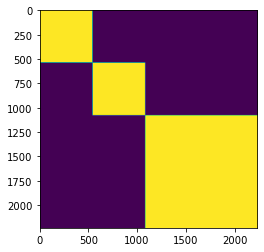

In [60]:
plt.imshow(adj)

In [61]:
log = torch.cat([mask.unsqueeze(0), adj.unsqueeze(0)],dim=0)

In [76]:
import wandb
import random


from torchvision import utils as vutils
#image = vutils.make_grid(model.model.model.model[0].edge_conv.mask)

random.seed(1)
wandb.init()
# define a metric we are interested in the minimum of
wandb.define_metric("loss", summary="min")
# define a metric we are interested in the maximum of
wandb.define_metric("acc", summary="max")
for i in range(1):
  log_dict = {
      "loss": random.uniform(0,1/(i+1)),
      "acc": random.uniform(1/(i+1),1),
      "im": wandb.Image(images)
  }
  wandb.log(log_dict)

_runtime,8
_timestamp,1644574494
_step,9


loss,▃█▄▄▁▃▃▂▁▂
acc,█▅▅▇▂▄▁▆█▁
_runtime,▁▁▁▁▅▅▅▅██
_timestamp,▁▁▁▁▅▅▅▅██
_step,▁▂▃▃▄▅▆▆▇█


wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade

InvalidVersionSpec: Invalid version '2.3.0>=2.1.0': invalid character(s)



(600, 400)

In [16]:
ww.get_concat_h(f,f)

AttributeError: 'Figure' object has no attribute 'width'

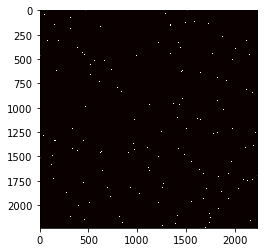

In [311]:
mask = model.model.model.model[0].edge_conv.mask
idxs = torch.argsort(batch.y)
mask = mask[idxs, :]
mask = mask[:, idxs]
plt.imshow(mask, cmap='hot', interpolation='nearest')



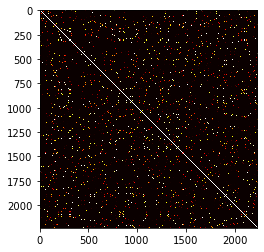

In [310]:
probs = model.model.model.model[0].edge_conv.probs.cpu().detach()
idxs = torch.argsort(batch.y)
probs = probs[idxs, :]
probs = probs[:, idxs]
plt.imshow(probs, cmap='hot', interpolation='nearest')


In [306]:
mask

tensor([[1.0000e+00, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 1.0000e+00, 1.0000e-06,  ..., 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e+00,  ..., 1.0000e-06, 1.0000e-06,
         1.0000e-06],
        ...,
        [1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e+00, 1.0000e-06,
         1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06, 1.0000e+00,
         1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06, 1.0000e-06,
         1.0000e+00]])